<h4>MOM6 diagnostic boundary fluxes of heat and its global budgets (enthalpy via CPL in BMOM)</h4> 

This notebook checks if the heat flux crossing the surface of the ocean is consistent with corresponding changes in the ocean temperature. This particular analysis is for testing and validating a MOM6/CESM BMOM when computing enthlapy fluxes via coupler.

Results from this notebook: 
1. Maps of surface boundary flux of heat crossing into the liquid seawater in MOM6;
2. Computation of self-consistency checks of the global heat budget to verify that the model is conserving heat over the global domain.  

CASEROOT: /glade/work/gmarques/cesm.cases/B/bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001

CIMEROOT: /glade/work/gmarques/cesm.sandboxes/cesm2_3_beta08.sbx/cime
    

**from Mariana:**

We now have a new CMEPS tag on master that has the enthalpy changes.
To get the new code you should check out cesm2_3_beta08

> git clone https://github.com/ESCOMP/cesm
> cd cesm
> git checkout cesm2_3_beta08

Then do the following:
1) edit the Externals.cfg to have the following change for CMEPS:

[cmeps]
tag = cmeps0.13.53
protocol = git
repo_url = https://github.com/ESCOMP/CMEPS.git
local_path = components/cmeps
required = True

2) edit the Externals.cfg to point to have mom use MOM6 externals point to your branch (gustavo/enthalpy_coupler) 

https://github.com/NCAR/MOM6/pull/214
 

In [1]:
# %pylab inline
import matplotlib.pyplot as plt
import netCDF4
import numpy 

In [2]:
casename = 'bmom.e23.f09_t061_zstar_N65.nuopc.enthalpy_via_cpl_PR_check.001'
path    = '/glade/scratch/gmarques/'+casename+'/run/'
static  = netCDF4.Dataset(path+'ocean.mom6.static.nc')
forcing = netCDF4.Dataset(path+'ocean.mom6.frc_0001.nc')
surface = netCDF4.Dataset(path+'ocean.mom6.sfc_0001.nc') ; tvar = 'time'

cp   = 3992.0
rho0 = 1035.0
n    = 1
print('Variables saved:')
for v in forcing.variables: print (v),
for v in surface.variables: print (v),
for v in static.variables: print (v),

Variables saved:
xq
yh
time
nv
xh
yq
scalar_axis
taux
tauy
ustar
PRCmE
lprec
fprec
evap
vprec
lrunoff
frunoff
seaice_melt
net_heat_coupler
net_heat_surface
frazil
sensible
latent
LwLatSens
SW
LW
Heat_PmE
seaice_melt_heat
heat_content_lrunoff
heat_content_frunoff
heat_content_lprec
heat_content_fprec
heat_content_vprec
heat_content_cond
heat_content_evap
heat_content_surfwater
internal_heat
heat_added
hfds
p_surf
salt_flux
salt_flux_in
vprec_global_adjustment
net_fresh_water_global_adjustment
salt_flux_global_restoring_adjustment
net_massout
net_massin
average_T1
average_T2
average_DT
time_bnds
xh
yh
time
xq
yq
SSH
SST
SSS
SSU
SSV
mass_wt
temp_int
salt_int
KPP_OBLdepth
xh
yh
time
xq
yq
geolon
geolat
geolon_c
geolat_c
geolon_u
geolat_u
geolat_v
geolon_v
areacello_cv
area_t
depth_ocean
wet
wet_c
wet_u
wet_v
Coriolis


In [4]:
# This section fills the fields used in this notebook.

#--------------------------------------------------------------
# geometric factors 
lon  = static.variables['geolon'][:]
lat  = static.variables['geolat'][:]
wet  = static.variables['wet'][:]
area = static.variables['area_t'][:]*wet


#--------------------------------------------------------------
# time in days 
time = surface.variables[tvar][:] *86400.


#--------------------------------------------------------------
# sea surface temperature 
sst = surface.variables['SST'][n]


#--------------------------------------------------------------
# \int \rho \, dz \, (1,Theta,S), with \rho = \rho_{0} for Bousssinesq.  
mass_wt = surface.variables['mass_wt']
tomint  = surface.variables['temp_int']
somint  = surface.variables['salt_int']


#--------------------------------------------------------------
# mass flux of water crossing ocean surface [kg/(m^2 s)]
# positive values indicate mass entering ocean; 
# negative values indicate mass leaving ocean. 

# net mass flux entering ocean 
net_massin = forcing.variables['net_massin'][n]

# net mass flux leaving ocean
net_massout = forcing.variables['net_massout'][n]

# evaporation (negative) and condensation (positive)
evap = forcing.variables['evap'][n]

# meltw, fresh water from melting/forming sea ice
meltw = forcing.variables['seaice_melt'][n]

# liquid runoff entering ocean (non-negative)
lrunoff = forcing.variables['lrunoff'][n]

# frozen runoff entering ocean (non-negative)
frunoff = forcing.variables['frunoff'][n]

# liquid precipitation entering ocean.
# note: includes exchanges with sea-ice, with 
#       melt adding mass to ocean; formation removing mass.
lprec = forcing.variables['lprec'][n]

# frozen precipitation entering ocean.
fprec = forcing.variables['fprec'][n]

# virtual precipitation arising from conversion of salt restoring to water flux
vprec = forcing.variables['vprec'][n]

# net mass flux crossing surface (including exchange with sea-ice)
PRCmE = forcing.variables['PRCmE'][n]


#--------------------------------------------------------------
# heat flux crossing ocean surface and bottom [Watt/m^2]
# positive values indicate heat entering ocean;
# negative values indicate heat leaving ocean.

# geothermal heating at ocean bottom 
#geothermal = forcing.variables['internal_heat'][n]

# net heat crossing ocean surface due to all processes, except restoring 
net_heat_surface = forcing.variables['net_heat_surface'][n]

# net heat passed through coupler from shortwave, longwave, latent, sensible.
# note: latent includes heat to vaporize liquid and heat to melt ice/snow. 
# note: sensible includes air-sea and ice-sea sensible heat fluxes.  
net_heat_coupler = forcing.variables['net_heat_coupler'][n]

# sum of longwave + latent + sensible
LwLatSens = forcing.variables['LwLatSens'][n]

# net shortwave passing through ocean surface
SW = forcing.variables['SW'][n]

# heating of liquid seawater due to formation of frazil sea ice
frazil = forcing.variables['frazil'][n]

# heat from melting/forming sea ice
melth = forcing.variables['seaice_melt_heat'][n]

# there is no restoring heat flux with this test case 
heat_restore = 0.0*forcing.variables['frazil'][n]

# net heat content associated with transfer of mass across ocean surface, 
# computed relative to 0C. Both diagnostics should be the same, though 
# they are computed differently in MOM6.   
heat_pme = forcing.variables['Heat_PmE'][n]
heat_content_surfwater = forcing.variables['heat_content_surfwater'][n]

# heat content associated with liquid precipitation 
heat_content_lprec = forcing.variables['heat_content_lprec'][n]

# heat content associated with meltw
#heat_content_meltw = forcing.variables['heat_content_icemelt'][n]

# heat content associated with frozen precipitation 
heat_content_fprec = forcing.variables['heat_content_fprec'][n]

# heat content associated with virtual precipitation 
heat_content_vprec = forcing.variables['heat_content_vprec'][n]

# heat content associated with liquid runoff 
heat_content_lrunoff = forcing.variables['heat_content_lrunoff'][n]

# heat content associated with frozen runoff 
heat_content_frunoff = forcing.variables['heat_content_frunoff'][n]

# heat content associated with liquid condensation 
heat_content_cond = forcing.variables['heat_content_cond'][n]

# heat content associated with evaporation 
heat_content_evap = forcing.variables['heat_content_evap'][n]

#--------------------------------------------------------------
# salt flux crossing ocean surface and bottom [kg/(m^2 s)]
# positive values indicate salt entering ocean; 
# negative values indicate salt leaving ocean.

salt_flux  = forcing.variables['salt_flux_in'][n]

# salt flux associated with surface restoring.
# salt_flux has contribution from sea ice + restoring, so we need to remove salt_flux (salt_flux_in)
salt_restore = forcing.variables['salt_flux'][n] - salt_flux

In [5]:
# for easy setup of subplots
def newSP(y,x):
    global __spv, __spi ; __spv = (y,x) ; __spi = 1 ; plt.subplot(__spv[0], __spv[1], __spi)
def nextSP():
    global __spv, __spi ; __spi = __spi + 1 ; plt.subplot(__spv[0], __spv[1], __spi)
    
# to reduce the amount of code when plotting fields
def make_plot(lon, lat, field, title, xmin=-280, xmax=80, ymin=-80, ymax=90, cmin=-200, cmax=200, xlabel=False):
   '''
   Uses pcolormesh to plot field as a function of lat and lon.
   Writes the max, min and ave values of field into the plot.
   '''
   global area

   field_min = numpy.amin(field)
   field_max = numpy.amax(field)
   field_ave = (field*area).sum() / area.sum()
   ch = plt.pcolormesh(lon,lat,field)
   cbax=plt.colorbar(ch, extend='both')
   plt.title(r''+title)
   if (cmin != 0.0 or cmax != 0.0):
     plt.clim(cmin,cmax)

   plt.xlim(xmin,xmax)
   plt.ylim(ymin,ymax)
   plt.ylabel(r'Latitude [$\degree$N]')
   if xlabel: plt.xlabel(r'Longitude')
   axis = plt.gca()
   axis.annotate('max=%5.2f\nmin=%5.2f\nave=%5.2f'%(field_max,field_min,field_ave),xy=(0.01,0.74),
              xycoords='axes fraction', verticalalignment='bottom', fontsize=8, color='black')


<hr --- />

<h1 align="center">Mass fluxes and global seawater mass budget</h1>

<h2 align="center">Global seawater mass budget consistency check</h2>

We compute the change in seawater mass over a given time period.  Two different methods are used, and the two methods should agree at the level of truncation error.  Note that "truncation error" precision is somewhat larger using offline diagnostics relative to online calculations, particularly if single precision output is saved rather than double precision.  

The net mass per time of water (units of kg/s) entering through the ocean boundaries is given by the area integral
$$\begin{equation*}
\mbox{boundary water mass entering liquid seawater} = \int Q_{W} \, dA,
\end{equation*}$$
where the net water flux (units of $\mbox{kg}~\mbox{m}^{-2}~\mbox{s}^{-1}$) is given by 
$$\begin{align*}
 Q_{W} &= {\tt PRCmE}
\end{align*}$$
A nonzero surface mass flux is associated with liquid and solid precipitation and runoff; evaporation and condensation; sea ice melt/formation; and surface restoring.  

The time change of liquid seawater mass is computed according to 
$$\begin{equation*}
\mbox{seawater mass change} = 
\frac{1}{\tau_{n+1} - \tau_{n} } \int dA \left(\int (\rho_{n+1} - \rho_{n}) \, \mathrm{d}z \right) 
\end{equation*}$$
where $\tau_{n+1} - \tau_{n}$ is the time increment in seconds.  Note that we make use of the MOM6 diagnostic for depth integrated density 
$$\begin{equation*}
 {\tt mass\_wt} =  \int \rho \, \mathrm{d}z.
\end{equation*}$$
For a Boussinesq fluid, the in-situ $\rho$ factor is set to $\rho_{0}$, in which case the diagnostic field {\tt mass\_wt} measures the thickness of a fluid column, multiplied by $\rho_{0}$.  For self-consistency, we should have the following equality holding to within truncation error  
$$\begin{equation*}
\boxed{
 \mbox{boundary water mass entering liquid seawater} = \mbox{seawater mass change}.
}
\end{equation*}$$

In [6]:
n0       = n-1
dmass_wt = mass_wt[n] - mass_wt[n0]
dt = time[n] - time[n0]
lhs = area * dmass_wt / dt
rhs = area * ( PRCmE )

print ('Total seawater mass at time step n  [kg seawater]  =',(mass_wt[n]*area).sum())
print ('Total seawater mass at time step n0 [kg seawater]  =',(mass_wt[n0]*area).sum())
print ('Total seawater mass content change [kg seawater]   =',dt*lhs.sum())
print ('Net water mass through boundaries [kg seawater]    =',dt*rhs.sum())
print ('Residual [kg seawater]                             =',dt*lhs.sum() - dt*rhs.sum())
print ('Non-dimensional residual (based on difference)     =',(  lhs.sum() - rhs.sum() )/lhs.sum())
print ('Non-dimensional residual (based on mass_wt[n])     =',(  lhs.sum() - rhs.sum() )/(mass_wt[n]*area).sum())

Total seawater mass at time step n  [kg seawater]  = 1.386147035366917e+21
Total seawater mass at time step n0 [kg seawater]  = 1.3861459060071994e+21
Total seawater mass content change [kg seawater]   = 1129359717803331.5
Net water mass through boundaries [kg seawater]    = 1129359717800783.0
Residual [kg seawater]                             = 2548.5
Non-dimensional residual (based on difference)     = 2.2564897894815658e-12
Non-dimensional residual (based on mass_wt[n])     = 2.1278579043387723e-23


<h2 align="center">Surface mass fluxes I: combined fields</h2>

/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


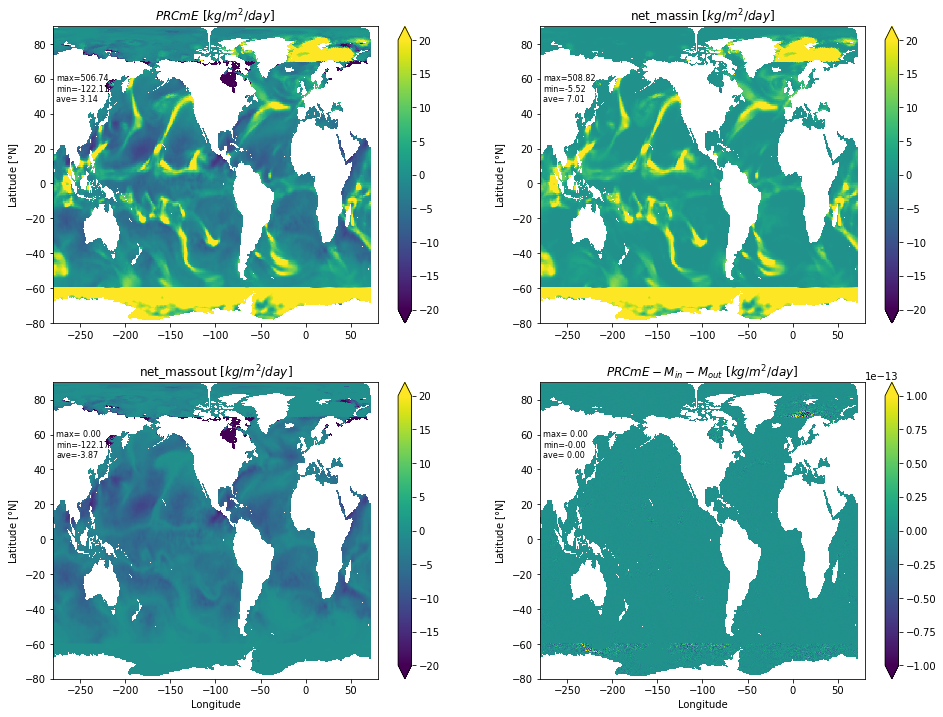

In [7]:
plt.figure(figsize=(16,12))
newSP(2,2);

field     = 86400.0*PRCmE
make_plot(lon,lat,field, '$PRCmE$ [$kg/m^2/day$]',cmin=-20,cmax=20)

nextSP()
field     = 86400.0*net_massin
make_plot(lon,lat,field, 'net_massin [$kg/m^2/day$]',cmin=-20,cmax=20)

nextSP()
field     = 86400.0*net_massout
make_plot(lon,lat,field, 'net_massout [$kg/m^2/day$]',cmin=-20,cmax=20,xlabel=True)

nextSP()
field     = 86400.0*(PRCmE - net_massout - net_massin)
make_plot(lon,lat,field, '$PRCmE - M_{in} - M_{out}$ [$kg/m^2/day$]',cmin=-1e-13,cmax=1e-13,xlabel=True)

<h2 align="center">Surface mass fluxes II: component fields</h2>

/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


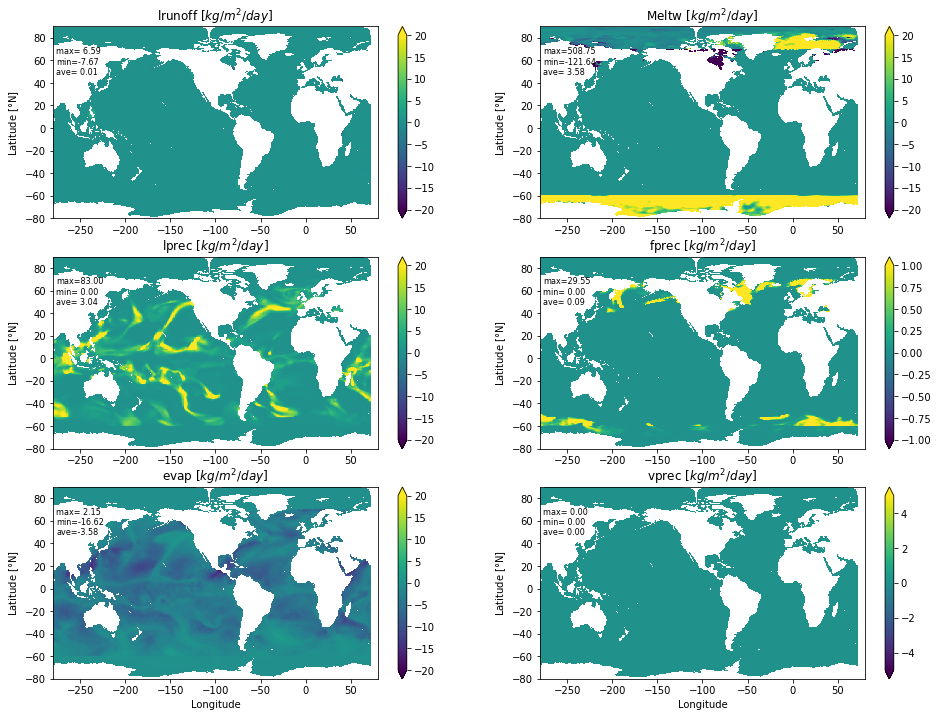

In [8]:
plt.figure(figsize=(16,12))
newSP(3,2);

field     = 86400.0*lrunoff
make_plot(lon,lat,field, 'lrunoff [$kg/m^2/day$]',cmin=-20,cmax=20)

nextSP()
field     = 86400.0*meltw
make_plot(lon,lat,field, 'Meltw [$kg/m^2/day$]',cmin=-20,cmax=20)

nextSP()
# lprec contains a contribution from sea ice melt/formation.
field     = 86400.0*lprec
make_plot(lon,lat,field, 'lprec [$kg/m^2/day$]',cmin=-20,cmax=20)

nextSP()
field     = 86400.0*fprec
make_plot(lon,lat,field, 'fprec [$kg/m^2/day$]',cmin=-1,cmax=1)

nextSP()
# evaporation and condensation
field     = 86400.0*evap
make_plot(lon,lat,field, 'evap [$kg/m^2/day$]',cmin=-20,cmax=20,xlabel=True)

nextSP()
field     = 86400.0*vprec
make_plot(lon,lat,field, 'vprec [$kg/m^2/day$]',cmin=-5,cmax=5,xlabel=True)

<h2 align="center">Surface mass flux self-consistency check</h2>

We will now check if PRCmE = lprec + fprec + lrunoff + frunoff + vprec + evap + meltw

/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


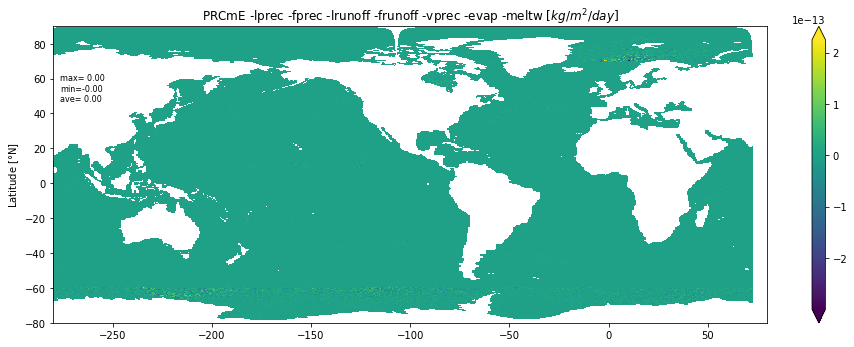

In [9]:
plt.figure(figsize=(16,12))
newSP(2,1);
# this should be within "truncation error" precision
field     = 86400.0*(PRCmE -lprec -fprec -lrunoff -frunoff -vprec -evap - meltw)
make_plot(lon,lat,field, 'PRCmE -lprec -fprec -lrunoff -frunoff -vprec -evap -meltw [$kg/m^2/day$]',cmin=0.0,cmax=0.0)


<hr --- />

<h1 align="center">Heat fluxes and global ocean heat budget</h1>

<h2 align="center">Global heat budget consistency check</h2>

We compute the change in seawater heat content over a given time period.  Two different methods are used, and the two methods should agree at the level of truncation error.  If larger differences exist, then there is a bug.

The net heat per time (units of Watts) entering through the ocean boundaries is given by the area integral
$$\begin{equation*}
\mbox{boundary heating of liquid seawater} = \int Q \, dA,
\end{equation*}$$
where the net heat flux (units of $\mbox{W}~\mbox{m}^{-2}~\mbox{s}^{-1}$) is given by 
$$\begin{align*}
 Q &= {\tt (net\_heat\_coupler + heat\_pme + frazil) + internal\_heat + heat\_restore} \\
   &= {\tt net\_heat\_surface + internal\_heat + heat\_restore}
\end{align*}$$
The time change of liquid seawater heat is computed according to 
$$\begin{equation*}
\mbox{seawater heat content change} = 
\frac{C_p }{\tau_{n+1} - \tau_{n} } \int dA \left(\rho_0 \int (\Theta_{n+1} - \Theta_{n}) \, \mathrm{d}z \right) 
\end{equation*}$$
 where $\tau_{n+1} - \tau_{n}$ is the time increment in seconds.  Note that we make use of the MOM6 diagnostic for depth integrated potential/conservative temperature  
$$\begin{equation*}
 {\tt tomint} = \rho_0 \int \Theta \, \mathrm{d}z,
\end{equation*}$$
 where the Boussinesq reference density, $\rho_{0}$, is used since this test case makes the Boussinesq approximation. For self-consistency, we should have the following equality holding to within truncation error  
$$\begin{equation*}
\boxed{
 \mbox{boundary heating of liquid seawater} = \mbox{seawater heat content change}.
}
\end{equation*}$$

In [10]:
n0      = n-1
dtomint = tomint[n] - tomint[n0]
dt      = time[n] - time[n0]
lhs     = cp * area * dtomint / dt
rhs     = area * ( net_heat_coupler + heat_pme  + frazil)
#rhs     = area * ( net_heat_surface)

print ('Total seawater heat at time step n  [Joules]   =',cp * (area * tomint[n]).sum())
print ('Total seawater heat at time step n0 [Joules]   =',cp * (area* tomint[n0]).sum())
print ('Total seawater heat content change [Joules]    =',dt*lhs.sum())
print ('Net heat through boundaries [Joules]           =',dt*rhs.sum())
print ('Residual [Joules]                              =',dt*lhs.sum() - dt*rhs.sum())
print ('Non-dimensional residual (based on difference) =',( lhs.sum() - rhs.sum() )/lhs.sum())
print ('Non-dimensional residual (based on tomint[n])  =',( lhs.sum() - rhs.sum()) / (cp * (area * tomint[n]).sum()))

Total seawater heat at time step n  [Joules]   = 1.979931751187772e+25
Total seawater heat at time step n0 [Joules]   = 1.9799384431611396e+25
Total seawater heat content change [Joules]    = -6.6919733669314494e+19
Net heat through boundaries [Joules]           = -6.691973366931939e+19
Residual [Joules]                              = 4898816.0
Non-dimensional residual (based on difference) = -7.326986721479322e-14
Non-dimensional residual (based on tomint[n])  = 2.866260413570082e-24


<h2 align="center">Basic components to surface heat flux</h2> 

Self-consistency check: net_heat_surface = heat_pme + frazil + net_heat_coupler 

/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


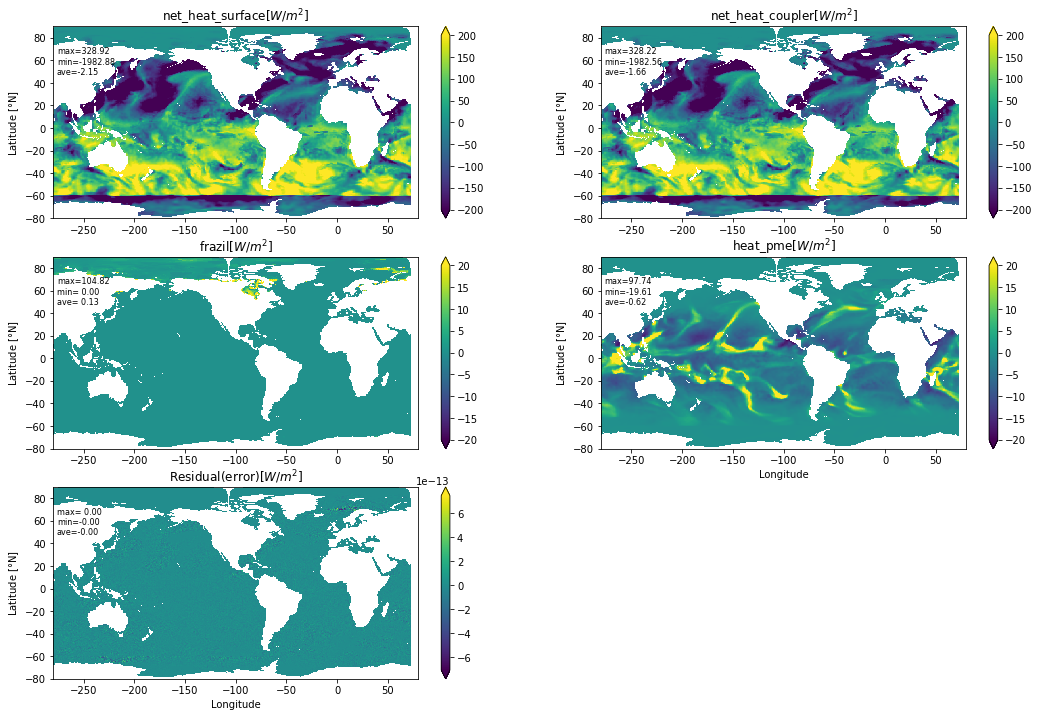

In [11]:
plt.figure(figsize=(18,12))
newSP(3,2);

field     = net_heat_surface
make_plot(lon,lat,field, 'net_heat_surface[$W/m^2$]')

nextSP()
field     = net_heat_coupler
make_plot(lon,lat,field, 'net_heat_coupler[$W/m^2$]')

nextSP()
field     = frazil
make_plot(lon,lat,field, 'frazil[$W/m^2$]',cmin=-20, cmax=20)

nextSP()
field     = heat_pme
make_plot(lon,lat,field, 'heat_pme[$W/m^2$]',cmin=-20,cmax=20,xlabel=True)

nextSP()
field = net_heat_surface-net_heat_coupler-frazil-heat_pme
make_plot(lon,lat,field, 'Residual(error)[$W/m^2$]',cmin=0.0,cmax=0.0,xlabel=True)

<h2 align="center">Heat fluxes crossing ocean surface via the coupler</h2> 

Heat fluxes crossing ocean surface via the coupler: net_heat_coupler = LwLatSens + SW + melth, where LwLatSens = LW + Latent + Sensible

/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


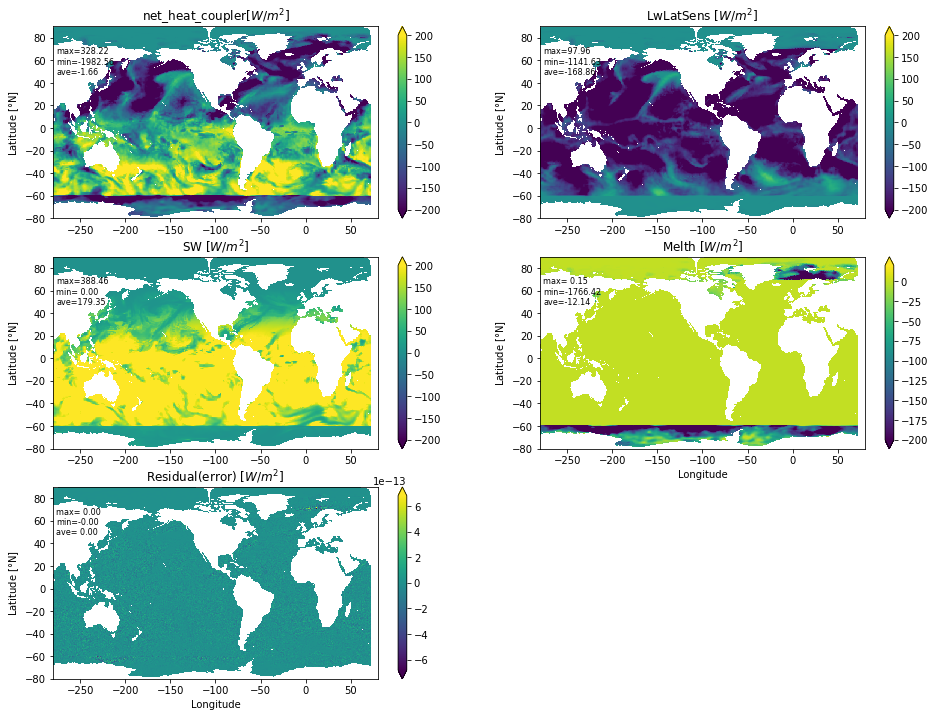

In [12]:
plt.figure(figsize=(16,12))
newSP(3,2);

field     = net_heat_coupler
make_plot(lon,lat,field, 'net_heat_coupler[$W/m^2$]',cmin=-200,cmax=200)

nextSP()
field     = LwLatSens
make_plot(lon,lat,field, 'LwLatSens [$W/m^2$]',cmin=-200,cmax=200)

nextSP()
field     = SW
make_plot(lon,lat,field, 'SW [$W/m^2$]',cmin=-200,cmax=200)

nextSP()
field     = melth
make_plot(lon,lat,field, 'Melth [$W/m^2$]',cmin=-200,cmax=20, xlabel=True)

nextSP()
field     = net_heat_coupler - SW - LwLatSens - melth
make_plot(lon,lat,field, 'Residual(error) [$W/m^2$]',cmin=0.0,cmax=0.0, xlabel=True)

<h2 align="center">Components of heat content from surface mass fluxes</h2>

Components of heat content of surface mass fluxes: heat_PmE = heat_content_lprec + heat_content_fprec + heat_content_vprec + heat_content_lrunoff + heat_content_frunoff + heat_content_cond + heat_content_evap

/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


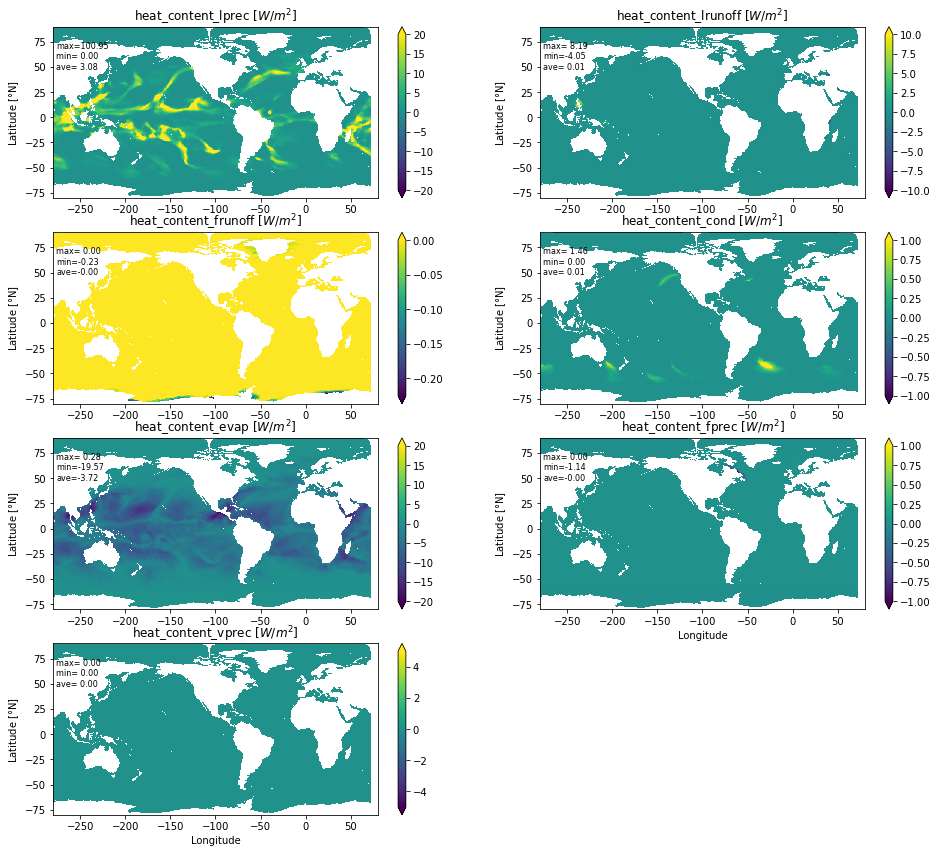

In [13]:
plt.figure(figsize=(16,14.5))
newSP(4,2);

field     = heat_content_lprec
make_plot(lon,lat,field, 'heat_content_lprec [$W/m^2$]',cmin=-20.0,cmax=20.0)

nextSP()
field     = heat_content_lrunoff
make_plot(lon,lat,field, 'heat_content_lrunoff [$W/m^2$]',cmin=-10.0,cmax=10.0)

nextSP()
field     = heat_content_frunoff
make_plot(lon,lat,field, 'heat_content_frunoff [$W/m^2$]',cmin=0.0,cmax=0.0)

nextSP()
field     = heat_content_cond
make_plot(lon,lat,field, 'heat_content_cond [$W/m^2$]',cmin=-1.0,cmax=1.0)

nextSP()
field     = heat_content_evap
make_plot(lon,lat,field, 'heat_content_evap [$W/m^2$]',cmin=-20.0,cmax=20.0)


nextSP()
field     = heat_content_fprec
make_plot(lon,lat,field, 'heat_content_fprec [$W/m^2$]',cmin=-1.0,cmax=1.0,xlabel=True)

nextSP()
field     = heat_content_vprec
make_plot(lon,lat,field, 'heat_content_vprec [$W/m^2$]',cmin=-5.0,cmax=5.0,xlabel=True)

<h2 align="center">Self-consistency of diagnosed heat content from mass entering and leaving ocean</h2>

/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


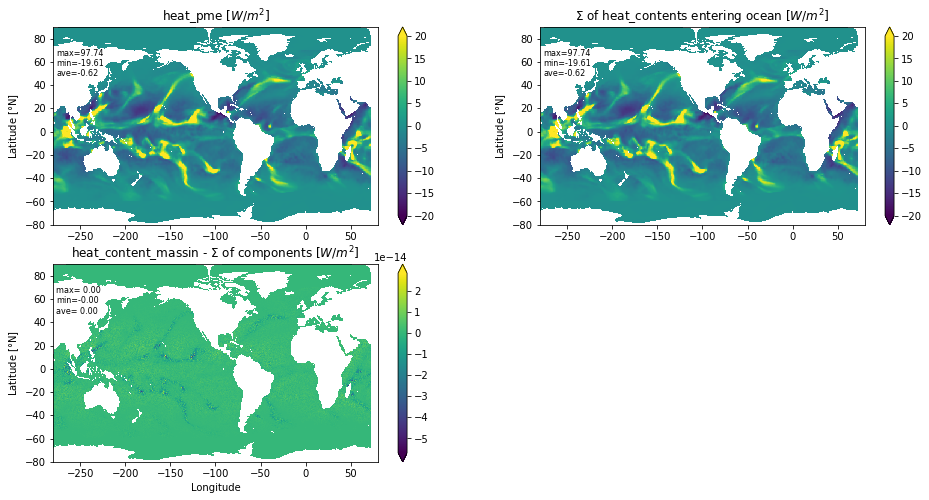

In [14]:
plt.figure(figsize=(16,8))
newSP(2,2);

heat_content_sum = ( heat_content_lprec + heat_content_fprec + heat_content_vprec + heat_content_evap +
                     heat_content_lrunoff  + heat_content_cond + heat_content_frunoff)

field     = heat_pme
make_plot(lon,lat,field, 'heat_pme [$W/m^2$]',cmin=-20.0,cmax=20.0)

nextSP()
field     = heat_content_sum
make_plot(lon,lat,field, '$\Sigma$ of heat_contents entering ocean [$W/m^2$]',cmin=-20.0,cmax=20.0)

nextSP()
# this should be within "truncation error" precision
field     = heat_pme - heat_content_sum
make_plot(lon,lat,field, 'heat_content_massin - $\Sigma$ of components [$W/m^2$]',cmin=0.0,cmax=0.0,xlabel=True)


<h2 align="center">Self-consistency between heat_pme and heat_content_surfwater</h2>

/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


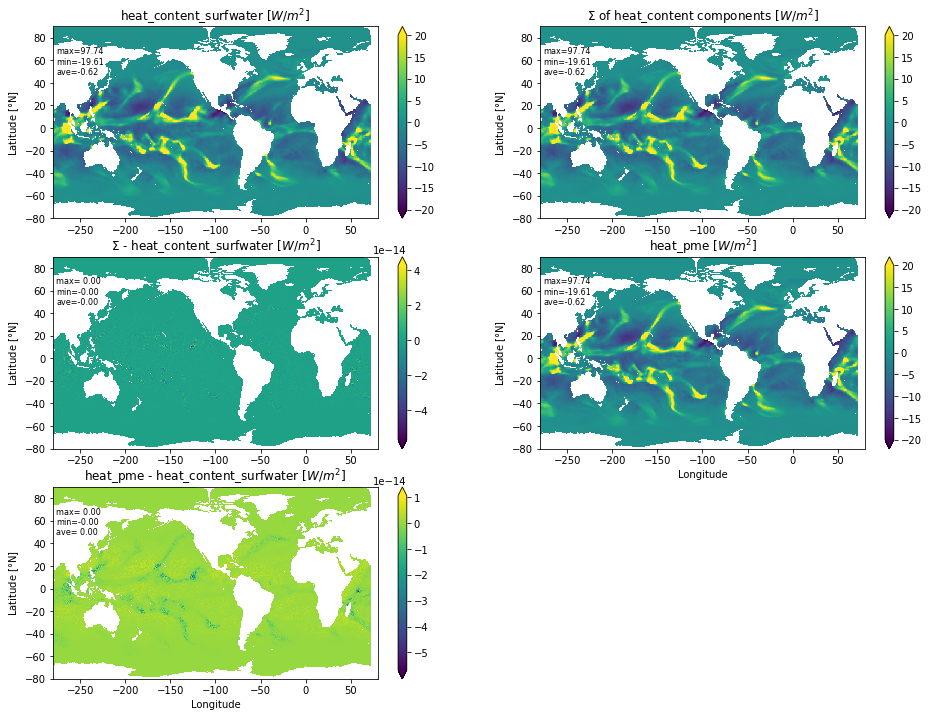

In [15]:
comp_sum = ( heat_content_lprec + heat_content_fprec + heat_content_vprec 
           + heat_content_frunoff + heat_content_cond + heat_content_evap + heat_content_lrunoff)

plt.figure(figsize=(16,12))
newSP(3,2);

field     = heat_content_surfwater
make_plot(lon,lat,field, 'heat_content_surfwater [$W/m^2$]',cmin=-20.0,cmax=20.0)

nextSP()
field     = comp_sum
make_plot(lon,lat,field, '$\Sigma$ of heat_content components [$W/m^2$]',cmin=-20.0,cmax=20.0)

nextSP()
# this should be within "truncation error" precision
field     = comp_sum - heat_content_surfwater
make_plot(lon,lat,field, '$\Sigma$ - heat_content_surfwater [$W/m^2$]',cmin=0.0,cmax=0.0)

nextSP()
field     = heat_pme
make_plot(lon,lat,field, 'heat_pme [$W/m^2$]',cmin=-20.0,cmax=20.0, xlabel=True)

nextSP()
# this should be within "truncation error" precision
field     = heat_pme - heat_content_surfwater
make_plot(lon,lat,field, 'heat_pme - heat_content_surfwater [$W/m^2$]',cmin=0.0,cmax=0.0, xlabel=True)


<hr --- />

<h1 align="center">Salt fluxes and global ocean salt budget</h1>

<h2 align="center">Global salt budget consistency check</h2>

We compute the change in seawater salt content over a given time period.  Two different methods are used, and the two methods should agree at the level of truncation error.  If larger differences exist, then there is a bug.

The net salt per time (units of kg/s) entering through the ocean boundaries is given by the area integral
$$\begin{equation*}
\mbox{boundary salt entering liquid seawater} = \int Q_{S} \, dA,
\end{equation*}$$
where the net salt flux (units of $\mbox{kg}~\mbox{m}^{-2}~\mbox{s}^{-1}$) is given by 
$$\begin{align*}
 Q_{S} &= {\tt salt\_flux} + {\tt salt\_restore}.
\end{align*}$$
A nonzero salt flux is associated with exchanges between liquid seawater and solid sea ice.  It also arises from simulations using a restoring boundary flux associated with damping to observed sea surface salinity.  Finally, there can be a salt flux when using sponges to damp the ocean interior back to an observed value.  

The time change of liquid seawater salt content is computed according to 
$$\begin{equation*}
\mbox{seawater salt content change} = 
\frac{1}{\tau_{n+1} - \tau_{n} } \int dA \left(\rho_0 \int (S_{n+1} - S_{n}) \, \mathrm{d}z \right) 
\end{equation*}$$
where $\tau_{n+1} - \tau_{n}$ is the time increment in seconds.  Note that we make use of the MOM6 diagnostic for depth integrated salinity 
$$\begin{equation*}
 {\tt somint} = \rho_0 \int S \, \mathrm{d}z,
\end{equation*}$$
where the Boussinesq reference density, $\rho_{0}$, is used since this test case makes the Boussinesq approximation. For self-consistency, we should have the following equality holding to within truncation error  
$$\begin{equation*}
\boxed{
 \mbox{boundary salt entering liquid seawater} = \mbox{seawater salt content change}.
}
\end{equation*}$$

In [17]:
n0      = n-1
dsomint = somint[n] - somint[n0]
time    = surface.variables[tvar][:]*86400.
dt      = time[n] - time[n0]
lhs     = 1.e-3 * area * dsomint / dt
rhs     = area * ( salt_flux + salt_restore )

print ('Total seawater salt at time step n  [kg salt]    =',(area * somint[n]).sum())
print ('Total seawater salt at time step n0 [kg salt]    =',(area * somint[n0]).sum())
print ('Total seawater salt content change [kg salt]     =',dt*lhs.sum())
print ('Net salt through boundaries [kg salt]            =',dt*rhs.sum())
print ('Residual [kg salt]                               =',dt*lhs.sum() - dt*rhs.sum())
print ('Non-dimensional residual (based on diference)    =',( lhs.sum() - rhs.sum() )/lhs.sum())
print ('Non-dimensional residual (based on somint[n])    =',( lhs.sum() - rhs.sum() )/((area * somint[n]).sum()))

Total seawater salt at time step n  [kg salt]    = 4.812716647240738e+22
Total seawater salt at time step n0 [kg salt]    = 4.8127161675814514e+22
Total seawater salt content change [kg salt]     = 4796592859837.447
Net salt through boundaries [kg salt]            = 4796592859894.099
Residual [kg salt]                               = -56.6513671875
Non-dimensional residual (based on diference)    = -1.1810639545734843e-11
Non-dimensional residual (based on somint[n])    = -1.3623924758329672e-26


/glade/scratch/gmarques/ipykernel_157968/3279565302.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ch = plt.pcolormesh(lon,lat,field)


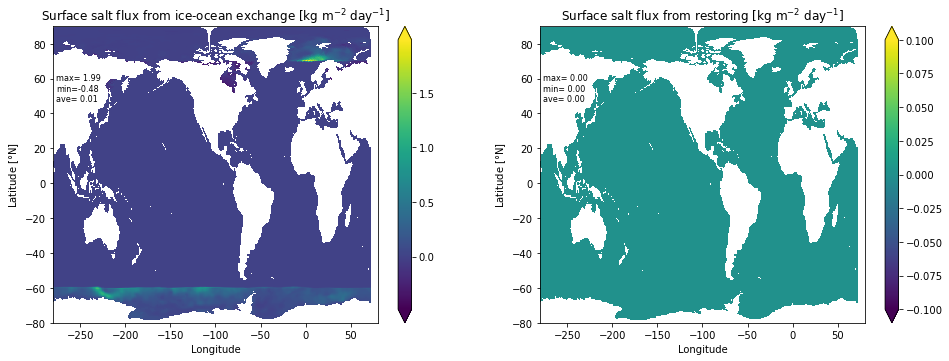

In [18]:
plt.figure(figsize=(16,12))
newSP(2,2)

field     = 86400.0*salt_flux
make_plot(lon,lat,field, 'Surface salt flux from ice-ocean exchange [kg m$^{-2}$ day$^{-1}$]',cmin=0.0,cmax=0.0,xlabel=True)

nextSP()
field     = 86400.0*salt_restore
make_plot(lon,lat,field, 'Surface salt flux from restoring [kg m$^{-2}$ day$^{-1}$]',cmin=0.0,cmax=0.0,xlabel=True)